<h1>Data Augmentation </h1> 


In this notebook, I'll train a Convolutional Neural Network with Regular data and Augmented data. The purpose of this notebook is to show that the Augmented data improves generalization performance.
>
Think of a scenario where a drone has to take a picture of an object. The drone is moving and the object can also possibly be moving. When an image is taken we aren't always going to get perfect images. The subject may not be perfectly centered in the image or the subject may be rotated in the image. In this case, a model trained on perfectly centered or rotated images won't perform well. This is why we train a model on rotated data so it can perform well on imperfect images.
>
There are two models; one trained on non rotated digits and one trained on rotated images. Then I'll test the models on a rotated testing dataset which will be more realistic and robust in terms of our scenario above.

### Table of Contents
<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#R_training_data">Rotated Training Data</a></li>

</ul>
<hr>

<h2>Preparation</h2>


In [1]:
!pip3 install torch torchvision torchaudio

In [ ]:
import requests

# Download a pretrained model for the drone images (because the training takes a long time) 
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/normal.pt'
response = requests.get(url)
with open('normal.pt', 'wb') as f:
    f.write(response.content)

In [ ]:
# Download a pretrained rotated dataset
url = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/meet_up/12.02.2020/rotated_data.pt'
response = requests.get(url)
with open('rotated_data.pt', 'wb') as f:
    f.write(response.content)

In [ ]:
# PIL library to show images
# !pip install Pillow==6.2.2

***Restart the kernel***


In [ ]:
# Import the libraries
# !pip install torchvision

# PyTorch Library
import torch
# PyTorch Neural Network Library
import torch.nn as nn
# Allows us to transform data
import torchvision.transforms as transforms
# Used to graph data and loss curves
import matplotlib.pylab as plt
# Allows us to use arrays to manipulate and store data
import numpy as np
# Allows us to download the dataset
import torchvision.datasets as dsets
# Allows us to access the filesystem
import os

Some useful functions for plotting 


Plot Cost and Accuracy vs Epoch Graph


In [ ]:
def plot_cost_accuracy(checkpoint):

# Plot the cost and accuracy
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(checkpoint['cost'], color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.set_xlabel('epoch', color=color)
    ax2.plot( checkpoint['accuracy'], color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()

Define the function <code>show_data</code> to plot out data samples as images.


In [25]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

Plot first 5 misclassified samples 


In [26]:
def plot_mis_classified(model, dataset):
    count=0
    for x, y in torch.utils.data.DataLoader(dataset=dataset, batch_size=1):
        z = model(x)
        _, yhat = torch.max(z, 1)
        if yhat != y:
            show_data((x, y))
            plt.show()
            count += 1
        if count >= 5:
            break

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Load Data</h2> 


Create a transform object  <code>compose</code> one will resize the image and convert it to a tensor, the second will also rotate the image Randomly rotate the image.

In [27]:
# Size of the images are 16 by 16
IMAGE_SIZE = 16

# Creating a group of transformations to created a rotated dataset
# Resizes the images, randomly rotates it, and then converts it to a tensor
compose_rotate = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.RandomAffine(45), transforms.ToTensor()])

# Creating a group of transformations to created a non rotated dataset
# Resizes the images then converts it to a tensor
compose = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

Load the training dataset by setting the parameters <code>train</code> to <code>True</code>. Use the transform defined above, one with rotated data one without.


In [28]:
# The transform parameters is set to the corresponding compose
train_dataset_rotate = dsets.MNIST(root='./data', train=True, download=True, transform=compose_rotate)
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=compose)

Load the testing dataset by setting the parameters train to <code>False</code>, where the data is <b>ALL</b> rotated.


In [29]:
# Load the testing dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=compose_rotate)

Each element in the rectangular tensor corresponds to a number representing a pixel intensity as demonstrated by the following image.


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter%206/6.2.1imagenet.png" width="550" alt="MNIST data image">


Plot the first sample 


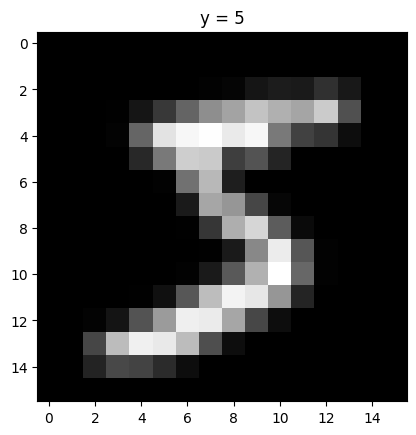

In [30]:
# The image for the first data sample
show_data(train_dataset[0])

Print out the first label, we can see this digit is a five


In [31]:
# The label for the first data element
train_dataset[0][1]

5

Now let's plot the first sample of the rotated training dataset


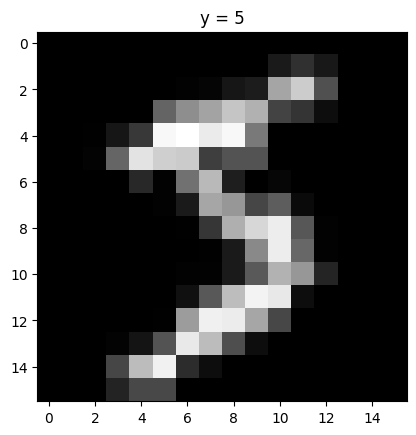

In [32]:
show_data(train_dataset_rotate[0])

See that this is the same sample but it is rotated as desired

<!--Empty Space for separating topics-->


<h2 id="CNN">Build a Convolutional Neural Network Class</h2>


Build a Convolutional Network class with two Convolutional layers and one fully connected layer. Pre-determine the size of the final output matrix. The parameters in the constructor are the number of output channels for the first and second layers.


In [ ]:
class CNN(nn.Module):

    # Constructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()

        # The reason to start with 1 channel is because there is a single black and white image
        # Channel Width after this layer is 16
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        # Channel Width after this layer is 8
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        # Channel Width after this layer is 8
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        # Channel Width after this layer is 4
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        # In total there are_2 (32) channels which are each 4 * 4 in size based on the width calculation above. Channels are squares.
        # The output is a value for each class
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)

    # Prediction
    def forward(self, x):
        # Puts the X value through each cnn, relu, and pooling layer and it is flattened for input into the fully connected layer
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

    # Outputs result of each stage of the CNN, relu, and pooling layers
    def activations(self, x):
        # Outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)

        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

<h2 id="regular_data">Regular Data</h2> 


Define the Convolutional Neural Network Classifier, Criterion function, Optimizer, and Train the Model


In [34]:
# Create the model object to be trained on regular data using CNN class
model = CNN(out_1=16, out_2=32)

Define the loss function, the optimizer, and the dataset loader 


In [ ]:
# Create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
# Create a Data Loader for the training data with a batch size of 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

This cell will train the model, it's commented out since it takes too long when I restart the kernel. Notice that I am not only training and saving the model here but also keeping track of important data like the cost and accuracy throughout the training process.

<h3 id="Result">Analyze Results</h3> 


Loads the data which is saved in `normal.pt`


In [36]:
checkpoint_normal = torch.load(os.path.join(os.getcwd(),'normal.pt'))

C:\Users\willl\AppData\Local\Temp\ipykernel_25088\2784942654.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_normal = torch.load(os.path.join(os.getcwd(),'nor

Plot Accuracy and Cost vs Epoch Graph


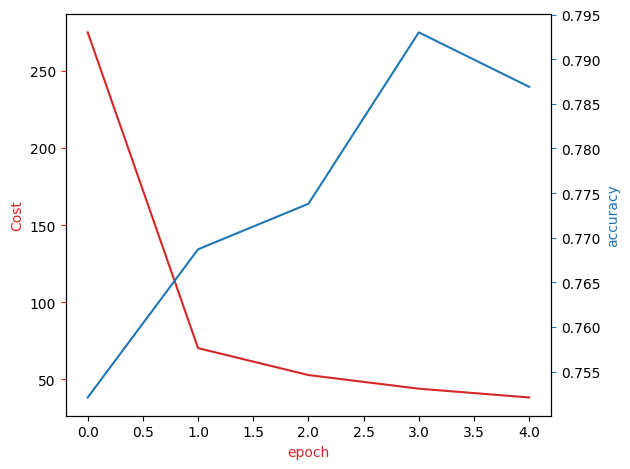

In [ ]:
# Using the helper function defined at the top and the cost and accuracy lists previously saved
plot_cost_accuracy(checkpoint_normal)

Five misclassified samples


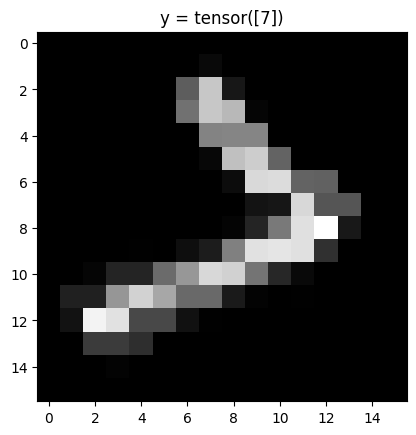

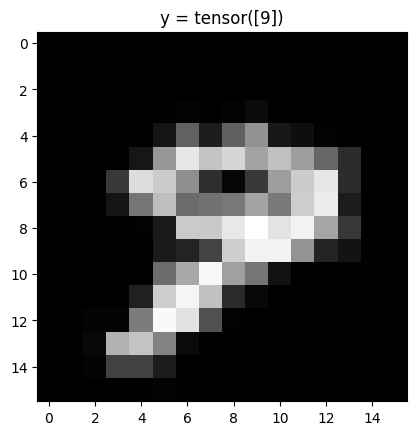

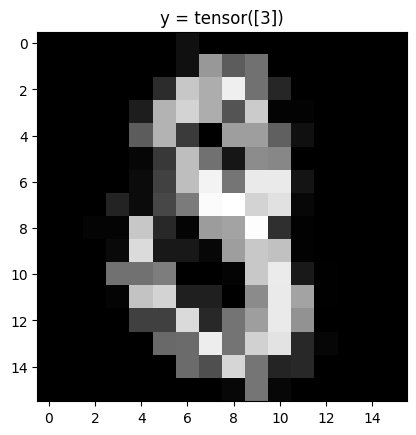

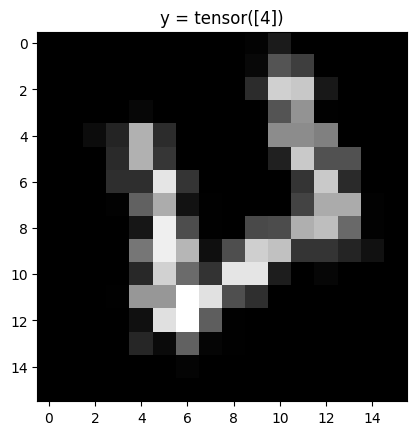

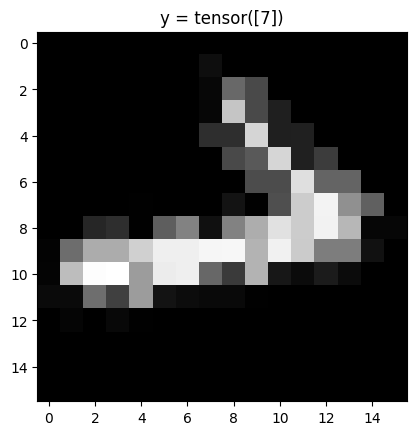

In [ ]:
# Using the saved model parameters we load them into a model to recreate the trained model
model.load_state_dict(checkpoint_normal['model_state_dict'])
# Setting the model to evaluation mode
model.eval()
# Using the helper function plot the first five misclassified samples
plot_mis_classified(model,validation_dataset)

<!--Empty Space for separating topics-->


<h2 id="R_training_data">Rotated Training Data</h2> 


Plot the loss and accuracy on the validation data:


In [ ]:
# Create the model object using CNN class
model_r = CNN(out_1=16, out_2=32)
# Create a criterion which will measure loss
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model_r.parameters(), lr = learning_rate)
# Create a Data Loader for the rotated training data with a batch size of 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_rotate, batch_size=100)
# Create a Data Loader for the rotated validation data with a batch size of 5000
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

This cell will train the model, commented it out for the same reason as the last one.

<h3 id="Result">Analyze Results</h3> 


Loads the data which is saved in `rotated_data.pt`


In [40]:
checkpoint_rotated= torch.load(os.path.join(os.getcwd(),'rotated_data.pt'))

C:\Users\willl\AppData\Local\Temp\ipykernel_25088\1667231719.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_rotated= torch.load(os.path.join(os.getcwd(),'rot

Plot Accuracy and Cost vs Epoch Graph


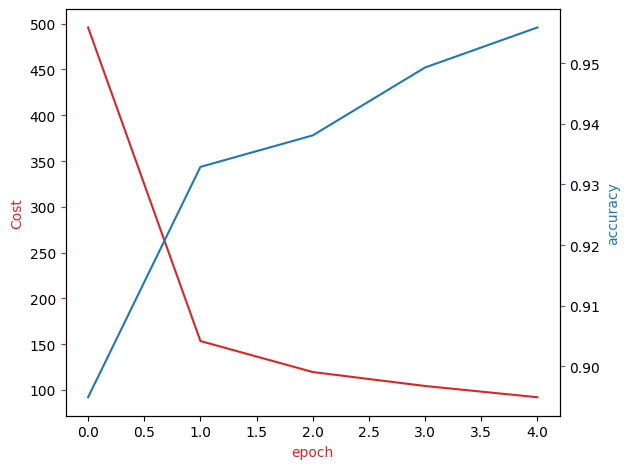

In [ ]:
# Using the helper function defined at the top and the cost and accuracy lists saved
plot_cost_accuracy(checkpoint_rotated)

Five misclassified samples


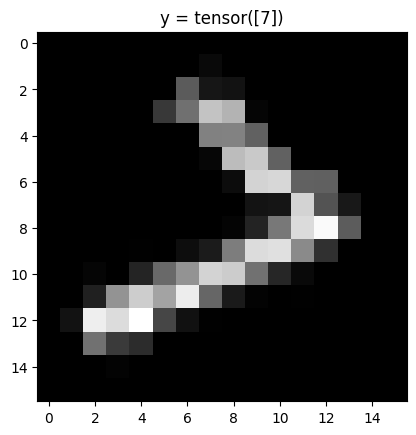

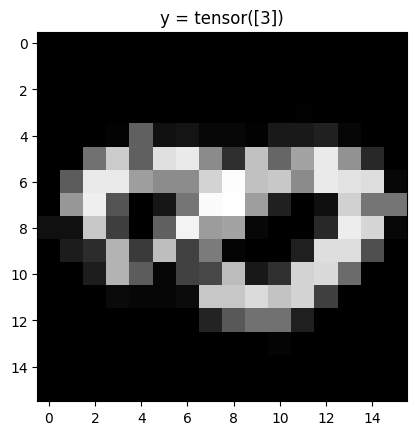

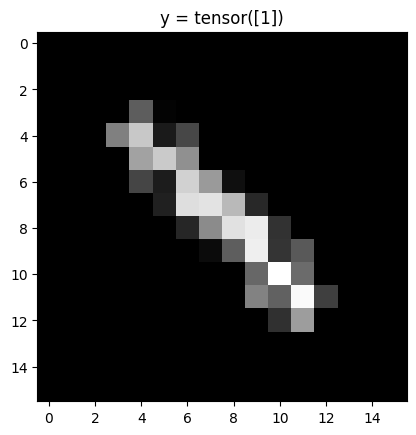

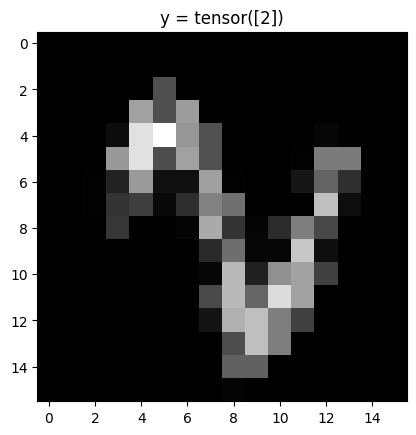

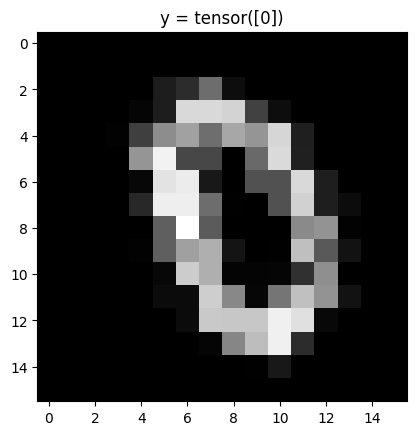

In [ ]:
# Using the saved model parameters, load them into a model to recreate the trained model
model_r.load_state_dict(checkpoint_rotated['model_state_dict'])
# Setting the model to evaluation mode
model.eval()
# Using the helper function plot the first five misclassified samples
plot_mis_classified(model_r,validation_dataset)

## Summary 


As you can see in the two Cost and Accuracy vs Epoch Graph the model trained on rotated data performs much better on the rotated validation data, 79% vs 95%+. By creating and training on rotated data allows the model to learn from unique data and have increased exposure to real life situations because data is not always perfect or rotated correctly.


## Conclusion

This notebook demonstrated the critical importance of data augmentation in improving model generalization. By training a CNN on both regular and augmented (rotated) MNIST data, we observed a significant performance difference when testing on real-world-like rotated images - improving accuracy from around 79% to over 95%.

### Key Findings:
1. **Augmentation improves robustness**: Models trained on augmented data perform substantially better on imperfect test data, making them more suitable for real-world applications.
2. **Practical applications**: This approach is especially valuable in scenarios like drone imagery, autonomous vehicles, or any vision system that must operate in dynamic environments where perfect image alignment can't be guaranteed.
3. **Implementation insights**: The `transforms.RandomAffine(45)` transformation was crucial, allowing the model to learn rotation-invariant features.

### Technical Impact Factors:
- **CNN architecture**: The two-layer CNN design with maxpooling provided sufficient capacity to learn rotation-invariant features when trained on augmented data.
- **Transformation parameters**: The 45° rotation range in data augmentation directly influenced the model's ability to handle rotated test images.
- **Training parameters**: While using a standard SGD optimizer with learning rate of 0.1, the model was able to effectively learn from the augmented data.

### Business Value:
Implementing data augmentation can dramatically improve model performance in real-world conditions without requiring additional data collection or more complex models. This translates to more reliable AI systems, fewer failures in production, and ultimately better user experiences and business outcomes across various computer vision applications.

The key lesson is that training data should reflect the variability expected in real-world scenarios - augmentation is a cost-effective way to achieve this when perfect data is hard to obtain or when deployment conditions are unpredictable.

<!--Empty Space for separating topics-->
